# Geometry of Imported Networks

The ``Imported`` geometry class is used to store the geometrical properties of imported networks.  When importing an extracted network into OpenPNM using any of the ``io`` classes, all the geometrical and topological properties are  lumped together on the *network* object.  OpenPNM is generally designed such that geometrical properties are stored on a *geometry* object, so this class address this issue. The main function of the ``Imported`` class is to automatically strip the geometrical properties off of the network and transfer them onto itself.

> **What problem does the Imported class solve?** Although OpenPNM can function with the geometrical properties on the network, a problem arises if the user wishes to add *more* pores to the network, such as boundary pores.  In this case, they will probably wish to add pore-scale models to calculate size information, say 'pore.volume'.  If they add this to the network, this model will overwrite the pre-existing 'pore.volume' values. The solution to this problem is an intrinsic part of OpenPNM: create a separate geometry object to manage it's own 'pore.volume' model and values. However, this **won't work**!  OpenPNM will not allow an array called 'pore.volume' to exist on the network *and* a geometry object. The reason is that networks store values for *every* pore, so when adding new pores the network the 'pore.volume' array will increase to accommodate them.  If you attempt to put 'pore.volume' values on the geometry object, you're are essentially putting *two* values in those locations.  Therefore, the ``Imported`` class solves this problem by first transferring the 'pore.volume' array (and all other geometrical properties) from the network to itself. 

In [1]:
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
ws = op.Workspace()
ws.settings['loglevel'] = 50  # Supress warnings, but see error messages

Let's start by generating a random network using the Delaunay class.  This will repreent an imported network:

In [2]:
np.random.seed(0)
pn = op.network.Delaunay(shape=[1, 1, 0], points=100)

This network generator adds nicely defined boundary pores around the edges/faces of the network.  Let's remove these for the sake of this example:

In [3]:
op.topotools.trim(network=pn, pores=pn.pores('boundary'))

KeyError: 'pore.boundary'

AttributeError: module 'openpnm.topotools' has no attribute 'plot_coordinates'

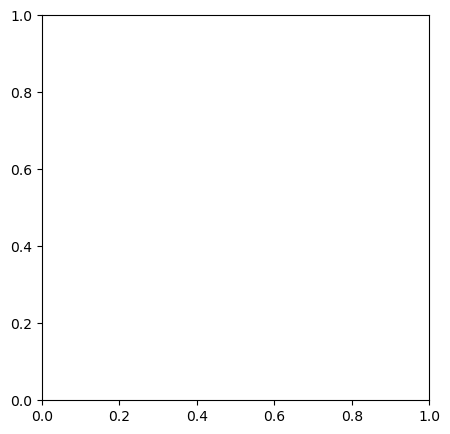

In [4]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
op.topotools.plot_coordinates(network=pn, c='r', ax=ax)
op.topotools.plot_connections(network=pn, ax=ax)

This network does not have any geometrical properties on it when generated.  To mimic the situation of an imported network, let's manually enter some values for ``'pore.diameter'``.  We'll just assign random numbers to illustrate the point:

In [5]:
pn['pore.diameter'] = np.random.rand(pn.Np)

Now when we ``print`` the network we'll see all the topological data ('pore.coords' and 'throat.conns'), all the labels that were added by the generator (e.g. 'pore.left'), as well as the new geometry info we just added ('pore.diameter'):

In [6]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Delaunay at 0x7fc8f89bfb80>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                     100 / 100
  2  pore.diameter                                                   100 / 100
  3  throat.conns                                                    286 / 286
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


OpenPNM was designed to work by assigning geomtrical information to **Geometry** objects.  The presence of 'pore.diameter' on the network can be a problem in some cases.  For instance, let's add some boundary pores to the left edge:

In [7]:
Ps = pn['pore.surface']*(pn['pore.coords'][:, 0] < 0.1)
Ps = pn.toindices(Ps)
op.topotools.add_boundary_pores(network=pn, pores=Ps, 
                                move_to=[0, None, None], 
                                apply_label='left')

KeyError: 'pore.surface'

Visualizing this networks shows the newl added pores where we intended:

AttributeError: module 'openpnm.topotools' has no attribute 'plot_coordinates'

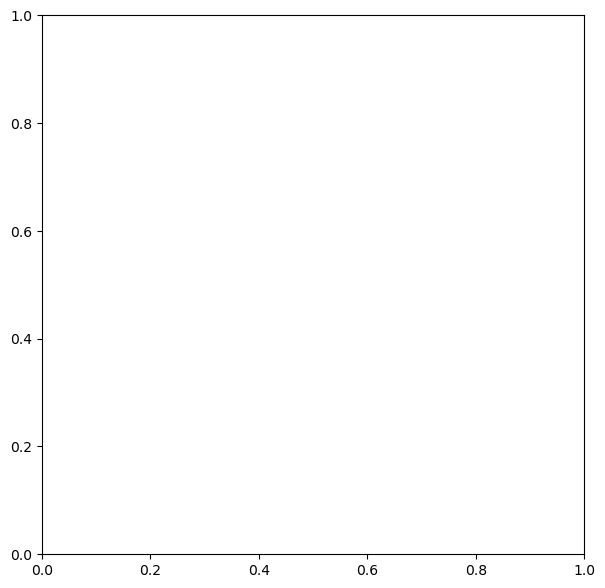

In [8]:
fig, ax = plt.subplots(figsize=[7, 7])
ax = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='r', ax=ax)
ax = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left'), c='g', ax=ax)
ax = op.topotools.plot_connections(network=pn, ax=ax)

Now we have internal pores (red) and boundary pores (green).  We would like to assign geometrical information to the boundary pores that we just created.  This is typically done by creating a **Geometry** object, then either assigning numerical values or attaching a pore-scale model that calculates the values.  The problem is that OpenPNM prevents you from having 'pore.diameter' on the network AND a geometry object at the same time. 

In [9]:
Ps = pn.pores('left')
Ts = pn.find_neighbor_throats(pores=Ps)
geo_bndry = op.geometry.GenericGeometry(network=pn, pores=Ps, throats=Ts)

KeyError: 'pore.left'

Now we we try to assign ``'pore.diameter'``, we'll get the following exception (The "try-except" structure is used for the purpose of this notebook example, but is not needed in an actual script):

In [10]:
try:
    geo_bndry['pore.diameter'] = 0
except Exception as e:
    print(e)

name 'geo_bndry' is not defined


The solution is to remove the geometrical information from the network *before* adding the boundary pores, and place them on their own geometry.  In this example it is easy to transfer the ``'pore.diameter'`` array, but in the case of a real extracted network there could be quite a few arrays to move.  OpenPNM has a facility for doing this: the ``Imported`` geometry class.

## Using the Imported Geometry Class
Let's create a network and add a geometric properties again, this time *before* adding boundary pores.

In [11]:
pn = op.network.Delaunay(shape=[1, 1, 0], points=100)
pn['pore.diameter'] = np.random.rand(pn.Np)

Here we pass the network to the ``Imported`` geometry class.  This class literally removes all numerical data from the network to itself.  Everything is moved except topological info ('pore.coords' and 'throat.conns') and labels ('pore.left').

In [12]:
geo = op.geometry.Imported(network=pn)

AttributeError: module 'openpnm' has no attribute 'geometry'

Printing ``geo`` reveals that the 'pore.diameter' array has been transferred from the network automatically:

In [13]:
print(geo)

NameError: name 'geo' is not defined

Now that the geometrical information is properly assigned to a geometry object, we can now use OpenPNM as intended.  Let's extend this network by adding a single new pore.

In [14]:
op.topotools.extend(network=pn, pore_coords = [[1.2, 1.2, 0]], labels='new')

The new pore can clearly be seen outside the top-right corner of the domain.

AttributeError: module 'openpnm.topotools' has no attribute 'plot_coordinates'

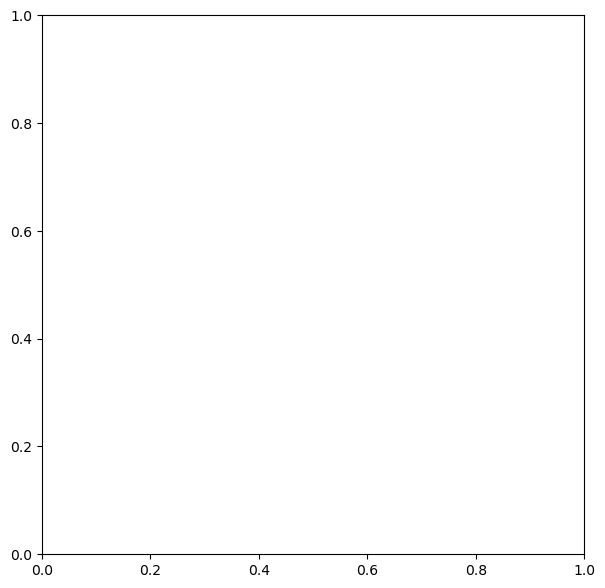

In [15]:
fig, ax = plt.subplots(figsize=[7, 7])
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='r', ax=ax)
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left'), c='g', ax=ax)
fig = op.topotools.plot_connections(network=pn, ax=ax)

We can now create a geometry just for this single pore and we will be free to add any properties we wish:

In [16]:
geo2 = op.geometry.GenericGeometry(network=pn, pores=pn.pores('new'))
geo2['pore.diameter'] = 2.0

AttributeError: module 'openpnm' has no attribute 'geometry'

In [17]:
print(geo2)

NameError: name 'geo2' is not defined

Note that the network has the ability to fetch the 'pore.diameter' array from the geometry sub-domain object and create a single full array containing the values from all the locations.  In the printout below we can see the value of 2.0 in the very last element, which is where new pores are added to the list.

In [18]:
print(pn['pore.diameter'])

[0.37321596 0.22286382 0.080532   0.08531092 0.22139645 0.10001406
 0.2650397  0.06614946 0.06560487 0.85627618 0.16212026 0.55968241
 0.77345554 0.45640957 0.15336888 0.19959614 0.43298421 0.52823409
 0.34944029 0.7814796  0.75102165 0.92721181 0.02895255 0.89569129
 0.39256879 0.8783725  0.69078478 0.98734876 0.75928245 0.36454463
 0.50106317 0.37638916 0.36491184 0.2609045  0.4959703  0.68173995
 0.27734027 0.52437981 0.11738029 0.15984529 0.04680635 0.97073144
 0.00386035 0.17857997 0.61286675 0.0813696  0.8818965  0.71962016
 0.96638997 0.50763555 0.30040368 0.54950057 0.93081872 0.52076144
 0.26720703 0.87739879 0.37191875 0.00138335 0.24768502 0.31823351
 0.85877747 0.45850317 0.44458729 0.33610227 0.88067812 0.94502678
 0.99189033 0.37674127 0.96614745 0.79187957 0.67568915 0.24488948
 0.21645726 0.16604782 0.92275661 0.29407666 0.45309425 0.49395783
 0.7781716  0.84423496 0.1390727  0.42690436 0.84285489 0.81803331
 0.10241376 0.15638335 0.30419869 0.07535907 0.424663   0.1076